In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

    100% |████████████████████████████████| 483.0MB 58.5MB/s 
    100% |████████████████████████████████| 2.0MB 1.5MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import decimal
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [4]:
torch.__version__

'0.4.1'

In [5]:
!pip install pillow==4.1.1
# %reload_ext autoreload
# %autoreload

    100% |████████████████████████████████| 5.7MB 6.5MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [0]:
training_dir = "/content/drive/My Drive/Siamese Neural Network/dataset1/train/"
testing_dir = "/content/drive/My Drive/Siamese Neural Network/dataset1/test/"
train_batch_size = 64
train_number_epochs = 100

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [0]:
folder_dataset = dset.ImageFolder(root=training_dir)

In [0]:
genuine_pairs = []
imposter_pairs = []

In [0]:
#genuine pairs(0)
k = 0
for i in range(0,370,1):
    if(i%10==0 and i!=0):
        k = k + 10
    for j in range(i+1,k+10,1):
        #print(i,j)
        genuine_pairs.append([folder_dataset.imgs[i][0], folder_dataset.imgs[j][0], 0])

In [0]:
#imposter pairs(1)
k=10
for i in range(0,370,1):
    for j in range(i+k,370,1):
        imposter_pairs.append([folder_dataset.imgs[i][0], folder_dataset.imgs[j][0], 1])
    k=k-1
    if(k == 0):
        k = 10

In [0]:
class SiameseNetworkDataset(Dataset):
    
    
    def __init__(self,genuine_pairs,imposter_pairs,imageFolderDataset,transform=None,should_invert=True):
        self.genuine_pairs = genuine_pairs
        self.imposter_pairs = imposter_pairs
        self.imageFolderDataset = imageFolderDataset 
        self.transform = transform
        self.should_invert = should_invert        
        
    def __getitem__(self,index):
        #choosing randomly betweeen genuine(0) and imposter(1) pair
        choice = random.randint(0,1)
        
        #using if else to choose a random pair
        if(choice == 0):
            #genuine pair(0)
            
            #select a genuine pair
            pair = random.choice(self.genuine_pairs)
            
            #image 1
            img0 = pair[0]
            
            #image 2
            img1 = pair[1]
            
            #genuine label
            label = pair[2]
            
        else:
            #imposter pair(1)
            
            #select an imposter pair
            pair = random.choice(self.imposter_pairs)
            
            #image 1
            img0 = pair[0]
            
            #image 2
            img1 = pair[1]
            
            #genuine label
            label = pair[2]
            
        #open the images
        img0 = Image.open(img0)
        img1 = Image.open(img1)
        
        #converting the images to black and white
        img0 = img0.convert("L")
        img1 = img1.convert("L")
 
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1, torch.from_numpy(np.array([int(label)], dtype=np.double))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)


In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, genuine_pairs = genuine_pairs, imposter_pairs = imposter_pairs,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()])                                                                      
                                       ,should_invert=False)


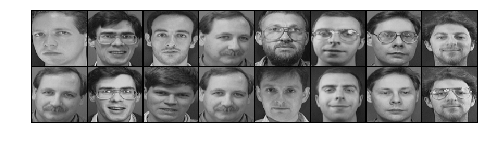

[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [14]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        #num_workers=8,
                        batch_size=8)

dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):

        super(SiameseNetwork, self).__init__()
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=10, stride=1, padding=0),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=0),
            nn.LeakyReLU(inplace=True),
            #nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256)
            
        )
        
        self.fc1 = nn.Sequential(
          nn.Linear(256 * 6 * 6, 4096),
          nn.Sigmoid()
        )
        
        self.fc2 = nn.Sequential(
          nn.Linear(4096,1)
        )
        
     
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
      
    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        # compute l1 distance
        diff = torch.abs(output1 - output2)
        output= self.fc2(diff)
        return output

In [0]:
#weights initializiation
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.01)
        m.bias.data.normal_(0.5, 0.01)

    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        
        
        m.bias.data.fill_(0)    

    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.2)
        m.bias.data.normal_(0.5, 0.01)

In [0]:
# Training the model

# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        #num_workers=8,
                        batch_size=train_batch_size)

In [0]:
net = SiameseNetwork().cuda().double()
#criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

Epoch number 0
 Current loss 0.5249001920426427



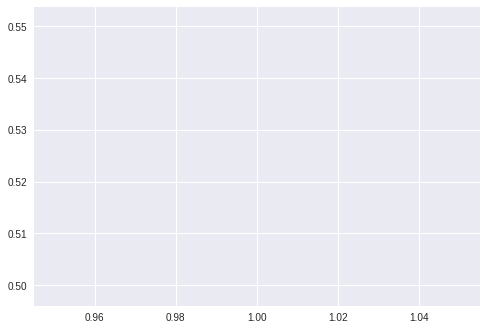

Epoch number 1
 Current loss 0.498342841425265

Epoch number 2
 Current loss 0.42415406635078984

Epoch number 3
 Current loss 0.40265986950031896

Epoch number 4
 Current loss 0.4388323212822972

Epoch number 5
 Current loss 0.4957572874778848

Epoch number 6
 Current loss 0.40119340024663963

Epoch number 7
 Current loss 0.3536922083346717

Epoch number 8
 Current loss 0.2915036837863742

Epoch number 9
 Current loss 0.2904860627546765

Epoch number 10
 Current loss 0.3255672669050317



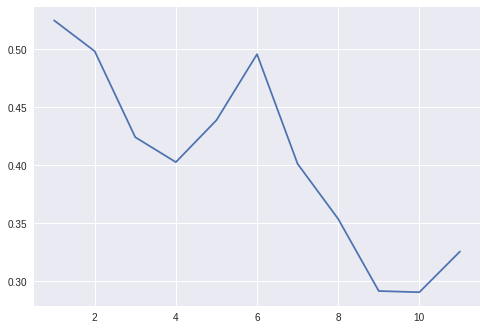

Epoch number 11
 Current loss 0.32075230906249347

Epoch number 12
 Current loss 0.40412040816067324

Epoch number 13
 Current loss 0.2662633748280582

Epoch number 14
 Current loss 0.24789084834480474

Epoch number 15
 Current loss 0.10997096090044099

Epoch number 16
 Current loss 0.17498508031051596

Epoch number 17
 Current loss 0.2777257414433031

Epoch number 18
 Current loss 0.15217627917333645

Epoch number 19
 Current loss 0.10141109393620346

Epoch number 20
 Current loss 0.14202562736470395



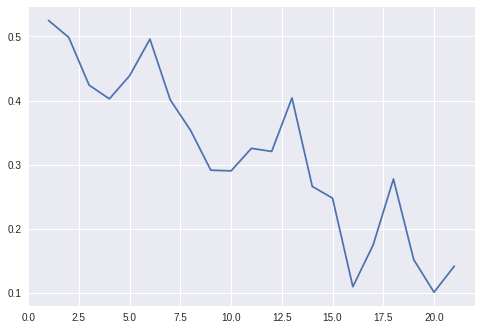

Epoch number 21
 Current loss 0.20847252048850887

Epoch number 22
 Current loss 0.16942456792289007

Epoch number 23
 Current loss 0.21852738314316278

Epoch number 24
 Current loss 0.07827876963165173

Epoch number 25
 Current loss 0.20695884957608615

Epoch number 26
 Current loss 0.07475370369191163

Epoch number 27
 Current loss 0.10039926179263167

Epoch number 28
 Current loss 0.12803467394229207

Epoch number 29
 Current loss 0.16146769444822456

Epoch number 30
 Current loss 0.040990610683484204



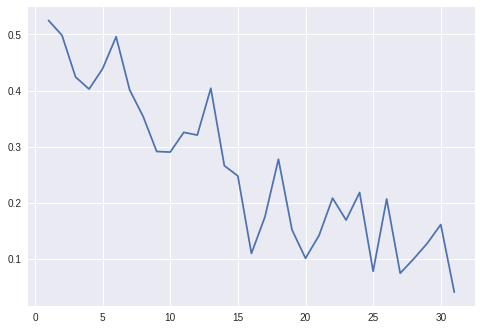

Epoch number 31
 Current loss 0.0636906161109511

Epoch number 32
 Current loss 0.07526759804143227

Epoch number 33
 Current loss 0.07694934189717763

Epoch number 34
 Current loss 0.07205575084786996

Epoch number 35
 Current loss 0.0859777435632476

Epoch number 36
 Current loss 0.10066852228447745

Epoch number 37
 Current loss 0.11495850099956835

Epoch number 38
 Current loss 0.04785355466241026

Epoch number 39
 Current loss 0.07464355325054467

Epoch number 40
 Current loss 0.069467066610063



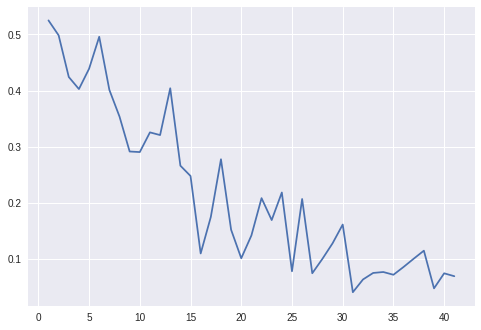

Epoch number 41
 Current loss 0.03666889579412463

Epoch number 42
 Current loss 0.12268144603221401

Epoch number 43
 Current loss 0.03544146251552272

Epoch number 44
 Current loss 0.022481041734304222

Epoch number 45
 Current loss 0.018131411777632493

Epoch number 46
 Current loss 0.04484335930420354

Epoch number 47
 Current loss 0.03685462060435258

Epoch number 48
 Current loss 0.02893393945187236

Epoch number 49
 Current loss 0.023316541883978505

Epoch number 50
 Current loss 0.02042463054687071



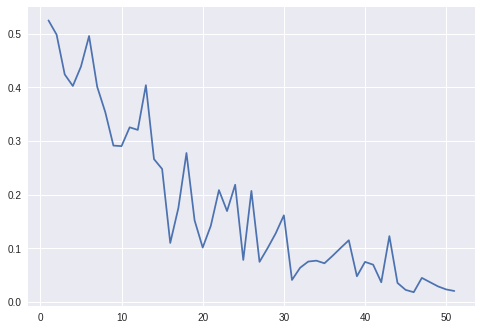

Epoch number 51
 Current loss 0.11993494366690816

Epoch number 52
 Current loss 0.024786049737413048

Epoch number 53
 Current loss 0.019863473716367513

Epoch number 54
 Current loss 0.03037565944587893

Epoch number 55
 Current loss 0.023458760585618865

Epoch number 56
 Current loss 0.009722930121774777

Epoch number 57
 Current loss 0.018517371653168288

Epoch number 58
 Current loss 0.025830737848698885

Epoch number 59
 Current loss 0.053866777203532

Epoch number 60
 Current loss 0.014287598109275162



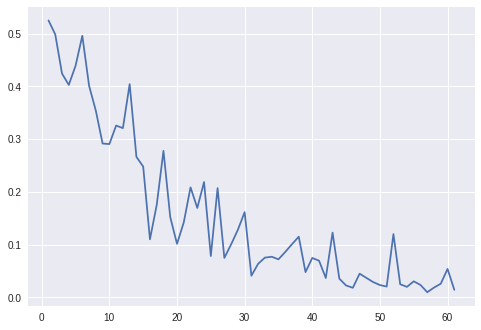

Epoch number 61
 Current loss 0.020166741645163255

Epoch number 62
 Current loss 0.06704612473354642

Epoch number 63
 Current loss 0.016745121762461627

Epoch number 64
 Current loss 0.009165750690316062

Epoch number 65
 Current loss 0.013923678874011596

Epoch number 66
 Current loss 0.01996082176292671

Epoch number 67
 Current loss 0.07074159666171326

Epoch number 68
 Current loss 0.021133712596303377

Epoch number 69
 Current loss 0.01590139803307882

Epoch number 70
 Current loss 0.013974010181628993



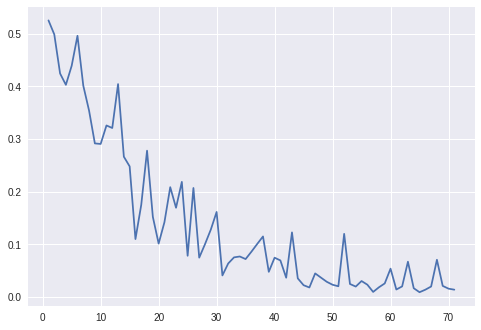

Epoch number 71
 Current loss 0.010345750330796287

Epoch number 72
 Current loss 0.010809523779984965

Epoch number 73
 Current loss 0.010348820869831256

Epoch number 74
 Current loss 0.01592383051563635

Epoch number 75
 Current loss 0.01993323925699886

Epoch number 76
 Current loss 0.009291315976972359

Epoch number 77
 Current loss 0.02226176378160671

Epoch number 78
 Current loss 0.01225485058613425

Epoch number 79
 Current loss 0.0060853862290038965

Epoch number 80
 Current loss 0.014160076202362244



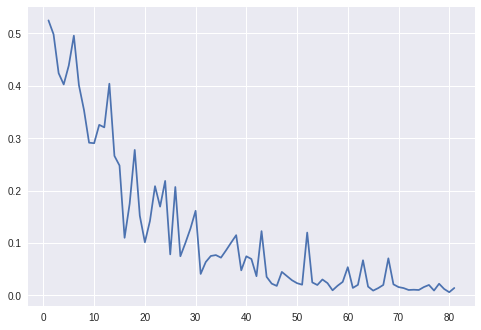

Epoch number 81
 Current loss 0.011330905252667632

Epoch number 82
 Current loss 0.02152167570193188

Epoch number 83
 Current loss 0.00805007238987434

Epoch number 84
 Current loss 0.006413952620931156

Epoch number 85
 Current loss 0.003766708430700279

Epoch number 86
 Current loss 0.004339867560162341

Epoch number 87
 Current loss 0.004200760364672175

Epoch number 88
 Current loss 0.006101101956094781

Epoch number 89
 Current loss 0.02165928714473672

Epoch number 90
 Current loss 0.010674869703552537



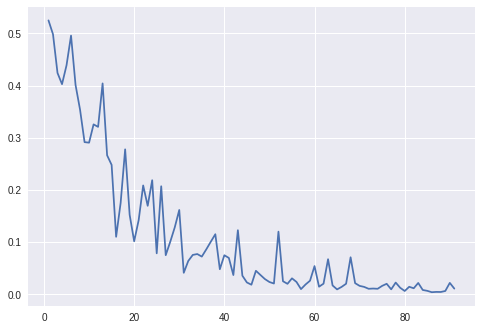

Epoch number 91
 Current loss 0.00931904546271133

Epoch number 92
 Current loss 0.001677614809154622

Epoch number 93
 Current loss 0.002714293774033908

Epoch number 94
 Current loss 0.0023794075770097373

Epoch number 95
 Current loss 0.011671418324587688

Epoch number 96
 Current loss 0.004371804930745666

Epoch number 97
 Current loss 0.0016055936901389282

Epoch number 98
 Current loss 0.0029806113464800692

Epoch number 99
 Current loss 0.005803257104301811



In [21]:
counter=[]
loss_history=[]
iteration_number=0
for epoch in range(0,100):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0.cuda()).double(), Variable(img1.cuda()).double() , Variable(label.cuda()).double()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        #output1,output2 = net(img0,img1)
        output = net(img0,img1)

        # Calculate Loss: Contrastive loss
        #loss_contrastive = criterion(output1,output2,label)
        loss = F.binary_cross_entropy_with_logits(output, label)
        
        # Getting gradients w.r.t. parameters
        loss.backward(retain_graph=True)
        #loss_contrastive.backward(retain_graph=True)
        
        # Updating parameters
        optimizer.step()
        
    print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
       
    iteration_number +=1
    counter.append(iteration_number)
    loss_history.append(loss.item())
    
    if epoch%10==0:
      show_plot(counter,loss_history)

In [22]:
# Saving the model
torch.save(net.cuda().state_dict(), "/content/drive/My Drive/Siamese Neural Network/model_windows.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [0]:
# Testing the model
folder_dataset_test = dset.ImageFolder(root=testing_dir)


In [0]:
genuine_pairs_test = []
imposter_pairs_test = []

In [0]:
#genuine pairs test(0)
k = 0
for i in range(0,30,1):
    if(i%10==0 and i!=0):
        k = k + 10
    for j in range(i+1,k+10,1):
        #print(i,j)
        genuine_pairs_test.append([folder_dataset.imgs[i][0], folder_dataset.imgs[j][0], 0])
              
#imposter pairs test(1)
k=10
for i in range(0,30,1):
    for j in range(i+k,30,1):
        imposter_pairs_test.append([folder_dataset.imgs[i][0], folder_dataset.imgs[j][0], 1])
    k=k-1
    if(k == 0):
        k = 10

In [0]:
# # Load the saved model
# net = SiameseNetwork().cuda().double()
# net.load_state_dict(torch.load("/content/drive/My Drive/Siamese Neural Network/model_windows.pt"))

In [0]:
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, genuine_pairs=genuine_pairs_test, imposter_pairs=imposter_pairs_test,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


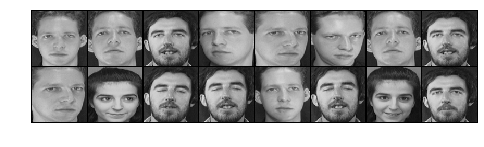

[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [28]:
vis_dataloader_test = DataLoader(siamese_dataset_test,
                        shuffle=False,
                        #num_workers=8,
                        batch_size=8)

dataiter = iter(vis_dataloader_test)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [0]:
test_dataloader = DataLoader(siamese_dataset_test,num_workers=6,batch_size=1,shuffle=True)

In [30]:
pred=0
correct=0
total=0
accuracy=0
for i, data in enumerate(test_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0.cuda()).double(), Variable(img1.cuda()).double() , Variable(label.cuda()).double()
        
        output = net(img0,img1)
        
        if output.item() > 5.5:
          pred=1
        else:
          pred=0

        if label.item() == pred:
          correct+=1
        total+=1

accuracy=(correct*100)/total
print(accuracy)

93.33333333333333
